# Processamento dos dados do ERA5 de Salinopolis

In [1]:
import conda

import os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap as bm

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

In [34]:
def uv2id(u, v):
    """
    Conversao de u e v para intensidade e direcao
    """
    i = np.sqrt(u ** 2 + v ** 2)
    d = (np.rad2deg(np.arctan2(u, v))) % 360.
    return i, d

def read_era5_param(pathname, filename, datei, datef, ponto):
    """
    Leitura dos parâmetros do ERA5
    """
    ds = xr.open_dataset(pathname + filename)
    
    # seleciona ponto mais proximo
    ds1 = ds.sel(longitude=ponto[1], latitude=ponto[0], method='nearest')
    ds2 = ds1.sel(time=slice(datei, datef))
    df = ds2.to_dataframe()
    df['ws'], df['wd'] = uv2id(df.u10, df.v10)
    return ds, df

datei = '2016-01-01 00:00:00'
datef = '2017-12-31 23:00:00'

path = os.environ['HOME'] + '/git/salinopolis/'
#     path_out = os.environ['HOME'] + '/gdrive/coppe/doutorado/output/'

# ponto mais proximo para pegar no era5
ponto = [0, -47]

# leitura dos dados
ds, df = read_era5_param(path, 'ERA5_param_salinopolis.nc', datei, datef, ponto)

df.index.name = 'date'

# salva dados do ERA5
df.to_csv(path + 'era5_param_salinopolis.csv')
#     freq.to_csv(path_out + 'era5_wave_freq.csv')
#     spec1.to_csv(path_out + 'era5_wave_spec1.csv')
#     spec2.to_netcdf(path=path_out + 'era5_wave_spec2.nc')

/usr/local/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/usr/local/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


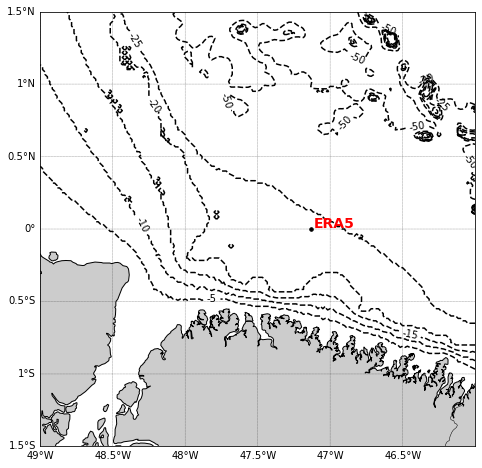

In [35]:
# Plot buoy location and ERA5 data point

def read_etopo(pathname, filename):
    """
    """
    etopo = xr.open_dataset(pathname + filename)
    etopo1 = etopo.sel(lon=slice(-49,-46), lat=slice(-1.5,1.5))
    return etopo1

def plot_bmop_loc(etopo1, df):
    """
    """
    # lat lon ERA5
    lat_era5 = df.latitude[0]
    lon_era5 = df.longitude[0]
    radius_era5_km = 0.3
    radius_era5 = 1.0 * radius_era5_km / 111.0 #km to degrees


    # cria matriz com lat lon
    lons, lats = np.meshgrid(etopo1.lon.data, etopo1.lat.data)

    # m = bm(projection='cyl',llcrnrlat=lat_fso-.03,urcrnrlat=lat_fso+.03,
    #          llcrnrlon=lon_fso-.04,urcrnrlon=lon_fso+.04, lat_ts=0,resolution='l')

    m = bm(projection='cyl',llcrnrlat=-1.5,urcrnrlat=1.5, 
           llcrnrlon=-49,urcrnrlon=-46, lat_ts=0,resolution='h')

    fig = plt.figure(figsize=(8,8))
    # lvls = np.arange(-4000,0,1)
    lvls = [-50, -25, -20, -15, -10, -5]
    CS1 = m.contour(lons, lats, etopo1.z, colors='black',
    #                 cmap=plt.cm.jet,
                    levels=lvls, alpha=1)
    plt.clabel(CS1, inline=1, inline_spacing=3, fontsize=10, fmt='%i')#, manual=manual_locations)
    
    plt.xticks(rotation=15)

    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents()
    m.drawmeridians(np.arange(-50, -46, 0.5), labels=[0,0,0,1], linewidth=0.3)
    m.drawparallels(np.arange(-2, 2, 0.5), labels=[1,0,0,0], linewidth=0.3)

    # plota posicoes e nomes
    m.plot(lon_era5, lat_era5, 'k.', markersize=7)
    # m.tissot(lon_era5, lat_era5, radius_era5, 30, color='k', alpha=0.2)
    plt.text(lon_era5+0.02, lat_era5+0.01, 'ERA5', color='r', fontweight='bold', fontsize=14)

#     m.plot(lon_buoy, lat_buoy, 'k.', markersize=7)
    # m.tissot(lon_buoy, lat_buoy, radius_buoy, 30, color='k', alpha=0.2)
#     plt.text(lon_buoy+0.02, lat_buoy+0.01, 'BMOP', color='r', fontweight='bold', fontsize=14)

    plt.xticks(rotation=15)
    return fig

path_etopo = os.environ['HOME']+ '/Documents/dados/etopo/'

# read ETOPO data
etopo1 = read_etopo(path_etopo, 'ETOPO-REMO.nc')

fig = plot_bmop_loc(etopo1, df)

plt.savefig(path + 'localizacao_era5_salinopolis.png', bbox_inches="tight")

In [22]:
df.columns

Index(['longitude', 'latitude', 'u10', 'v10', 'mwd', 'mwp', 'swh', 'ws', 'wd'], dtype='object')

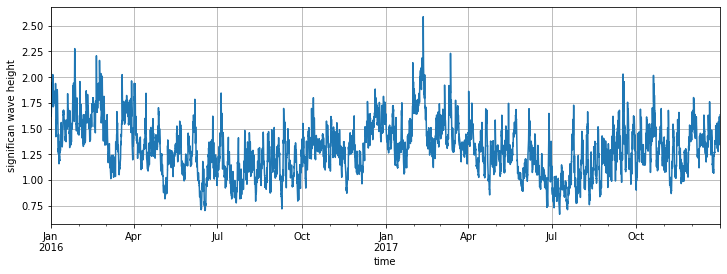

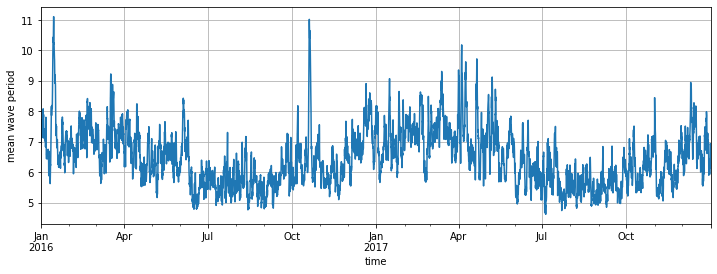

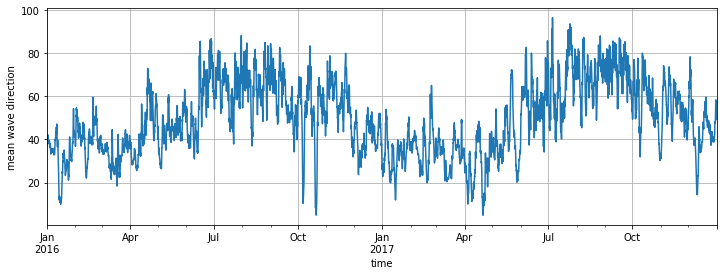

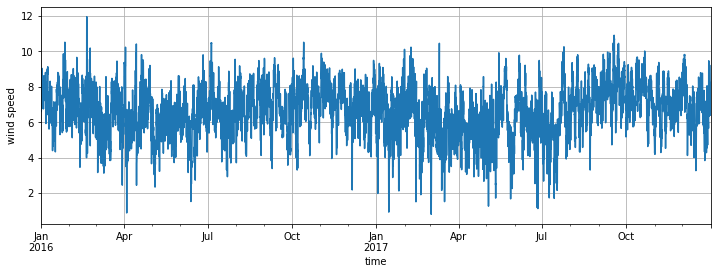

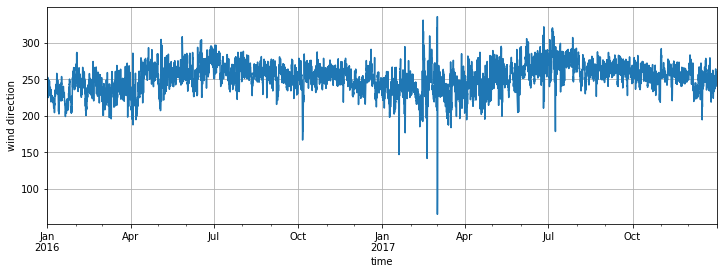

In [32]:
l = ['significan wave height', 'mean wave period', 'mean wave direction',
     'wind speed', 'wind direction']

cont = 0
for c in ['swh', 'mwp', 'mwd', 'ws', 'wd']:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    df[c].plot(ax=ax, grid='on')
    ax.set_ylabel(l[cont])
    fig.savefig('{}.png'.format(l[cont]))
    cont += 1